In [1]:
import keras
import json
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K 

import tensorflow as tf


## First glance at the data

In [2]:
HOME_DIR = '/Users/uliana/Documents/Coursera/Brain Tumor Auto-Segmentation for Magnetic Resonance Imaging (MRI)/Task10_Colon'
DATA_DIR = HOME_DIR

In [3]:
import os
example_pic = os.path.join(HOME_DIR, 'imagesTr/colon_005.nii.gz')
example_label = os.path.join(HOME_DIR, 'labelsTr/colon_005.nii.gz')

In [4]:
img = nib.load(example_pic)
type(img)

nibabel.nifti1.Nifti1Image

In [5]:
img_data = img.get_fdata()
type(img_data)

numpy.ndarray

In [6]:
img_data.shape

(512, 512, 98)

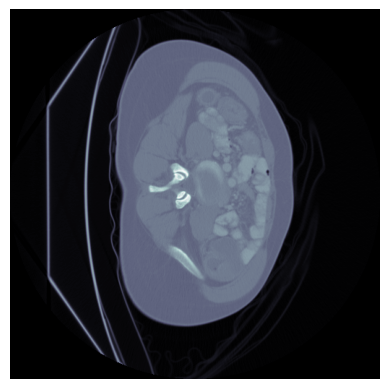

In [7]:
slice = plt.imshow(img_data[:, :, 44], cmap='bone')
plt.axis('off')
plt.show()

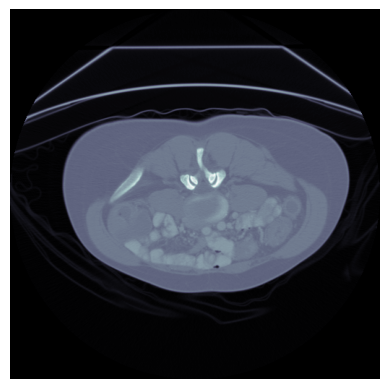

In [8]:
plt.imshow(ndi.rotate(img_data[:,:, 44], 270), cmap='bone')
plt.axis('off')
plt.show()

In [9]:
label = nib.load(example_label)
type(label)

nibabel.nifti1.Nifti1Image

In [10]:
label_data = label.get_fdata()
type(label_data)

numpy.ndarray

### Visualizing true values

White spot is tumor

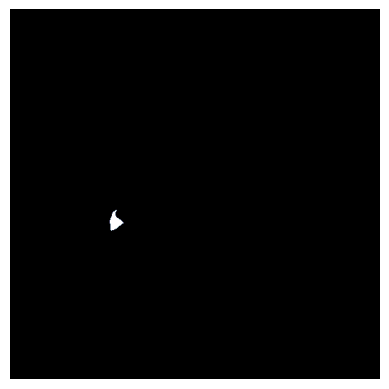

In [11]:
plt.imshow(ndi.rotate(label_data[:,:, 44], 270), cmap='bone')
plt.axis('off')
plt.show()

(-0.5, 511.5, 511.5, -0.5)

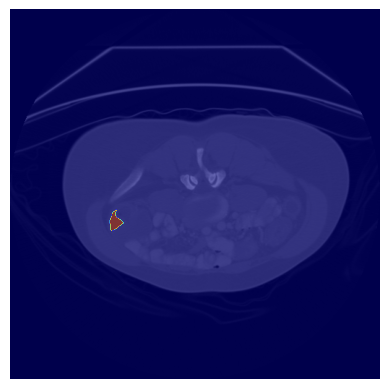

In [12]:
plt.imshow(ndi.rotate(img_data[:,:, 44], 270), cmap='gray')
plt.imshow(ndi.rotate(label_data[:,:, 44], 270), cmap='jet', alpha=0.6)
plt.axis('off')

### Lokalizing tumor on an mri image

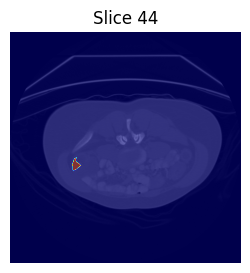

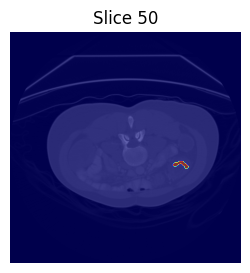

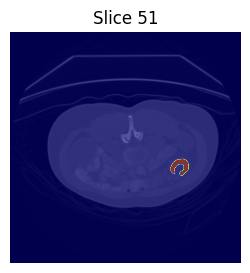

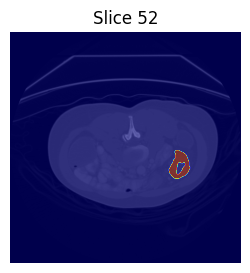

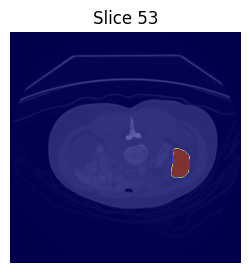

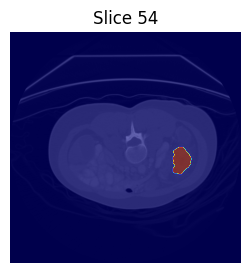

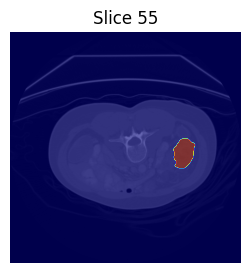

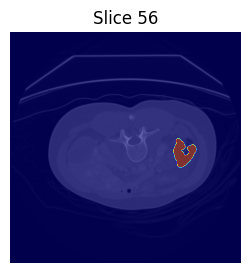

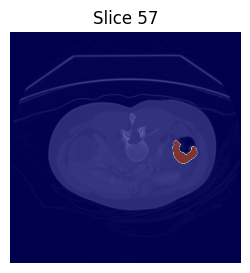

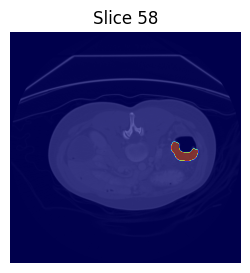

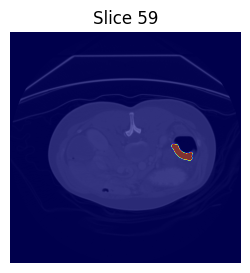

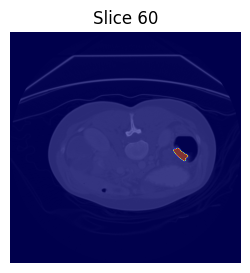

In [13]:
for i in range(98):
    if np.any(label_data[:, :, i] == 1):
        plt.figure(figsize=(3, 3))
        plt.imshow(ndi.rotate(img_data[:,:, i], 270), cmap='gray')
        plt.imshow(ndi.rotate(label_data[:,:, i], 270), cmap='jet', alpha=0.6)
        plt.title(f'Slice {i}')
        plt.axis('off')
    
        plt.show()


## Standartize the data

### Get subvolumes

#### Subvolumes are required due to the limited computational power
Make sure to obtain subvolumes containing at least 5 % of tumor
as the data is highly imbalanced

In [14]:
img_data

array([[[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.]],

       [[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024., ..., -1024., -1024., -1024.],
        ...,
        [-10

In [42]:
def get_subvolume(image, label, orig_x=512, orig_y=512, orig_z=98,
                   output_x=100, output_y=100, output_z=10,
                   num_classes=2, max_tries=1000,
                   background_threshold=0.95):

    X = None
    y = None

    tries = 0

    print(image.shape)
    print(label.shape)

    while tries < max_tries:
        start_x = np.random.randint(0, orig_x - output_x + 1)
        start_y = np.random.randint(0, orig_y - output_y + 1)
        start_z = np.random.randint(0, orig_z - output_z + 1)

        y = label[start_x: start_x+ output_x,
                start_y: start_y+ output_y,
                start_z: start_z+ output_z
                ]
        
        y = keras.utils.to_categorical(y, num_classes)
        b_ratio = np.sum(y[..., 0]) / (output_x * output_y * output_z)

        tries += 1

        if b_ratio < background_threshold:

            X = np.copy(image[start_x: start_x + output_x,
                                    start_y: start_y + output_y,
                                    start_z: start_z + output_z])
            print(b_ratio)

            y = np.moveaxis(y, -1, 0)[1:, :, :, :]

            return X, y

  
    print(f"Tried {tries} times to find a sub-volume. Giving up...")

get_subvolume(image=img_data, label=label_data)

(512, 512, 98)
(512, 512, 98)
0.87577


(array([[[-109.,  -95.,  -86., ...,  -88.,  -87.,  -94.],
         [-100.,  -96.,  -94., ...,  -95.,  -91.,  -91.],
         [-105.,  -92.,  -94., ..., -102.,  -87.,  -91.],
         ...,
         [-861., -898., -927., ..., -932., -860., -794.],
         [-874., -845., -891., ..., -928., -858., -816.],
         [-872., -803., -824., ..., -874., -856., -812.]],
 
        [[-104.,  -95.,  -86., ...,  -85.,  -86.,  -95.],
         [ -92., -102.,  -97., ...,  -92.,  -85.,  -98.],
         [ -92.,  -84.,  -99., ..., -101.,  -88.,  -92.],
         ...,
         [-874., -967., -942., ..., -894., -876., -827.],
         [-864., -896., -925., ..., -936., -873., -812.],
         [-866., -829., -859., ..., -908., -850., -815.]],
 
        [[ -98.,  -94.,  -89., ...,  -85.,  -90.,  -85.],
         [ -92., -102.,  -97., ...,  -85.,  -77.,  -85.],
         [ -97.,  -78.,  -99., ...,  -86.,  -78.,  -79.],
         ...,
         [-891., -994., -919., ..., -874., -937., -855.],
         [-877., -946., 

### Checking subvolumes

(512, 512, 98)
(512, 512, 98)
0.88759


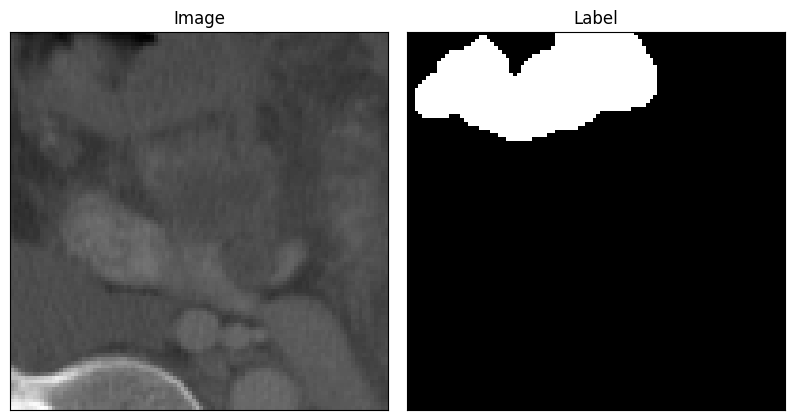

In [157]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 10], squeeze=False)

    ax[0][0].imshow(X[:, :, X.shape[2] // 2], cmap='gray')
    ax[0][0].set_title('Image')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    
    ax[0][1].imshow(y[:, :, y.shape[2] // 2], cmap='gray')
    ax[0][1].set_title('Label')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


X, y = get_subvolume(image=img_data, label=label_data)
visualize_patch(X, y[0])


(512, 512, 98)
(512, 512, 98)
0.86147


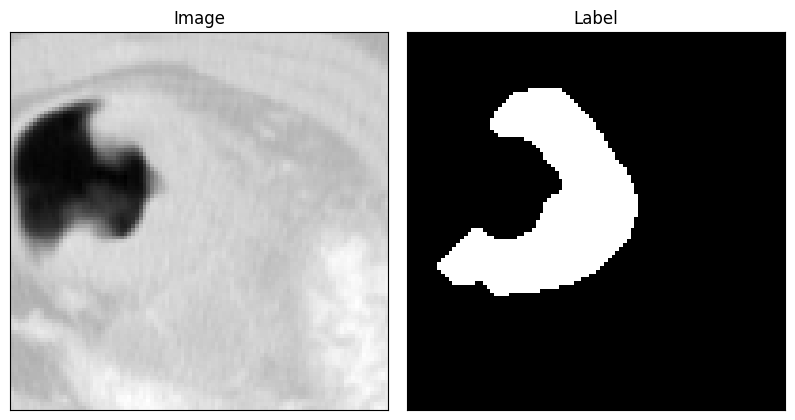

In [160]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_patch(X, y):
    fig, ax = plt.subplots(1, 2, figsize=[10, 10], squeeze=False)

    ax[0][0].imshow(X[:, :, X.shape[2] // 2], cmap='gray')
    ax[0][0].set_title('Image')
    ax[0][0].set_yticks([])
    ax[0][0].set_xticks([])
    
    ax[0][1].imshow(y[:, :, y.shape[2] // 2], cmap='gray')
    ax[0][1].set_title('Label')
    ax[0][1].set_xticks([])
    ax[0][1].set_yticks([])
    
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    plt.show()


X, y = get_subvolume(image=img_data, label=label_data)
visualize_patch(X, y[0])
